In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [5]:
import os
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [9]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


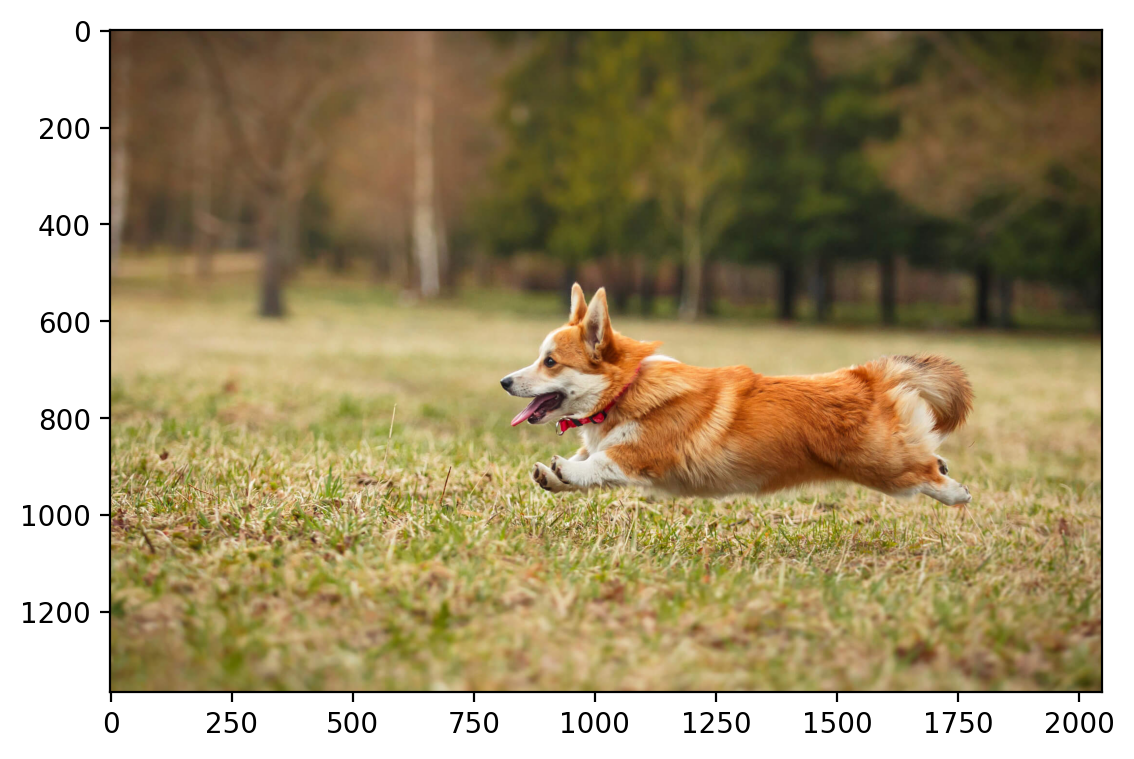

In [10]:
plt.imshow(rearrange(img, 'c h w -> h w c'))

In [11]:
crop = torchvision.transforms.functional.crop(img, 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

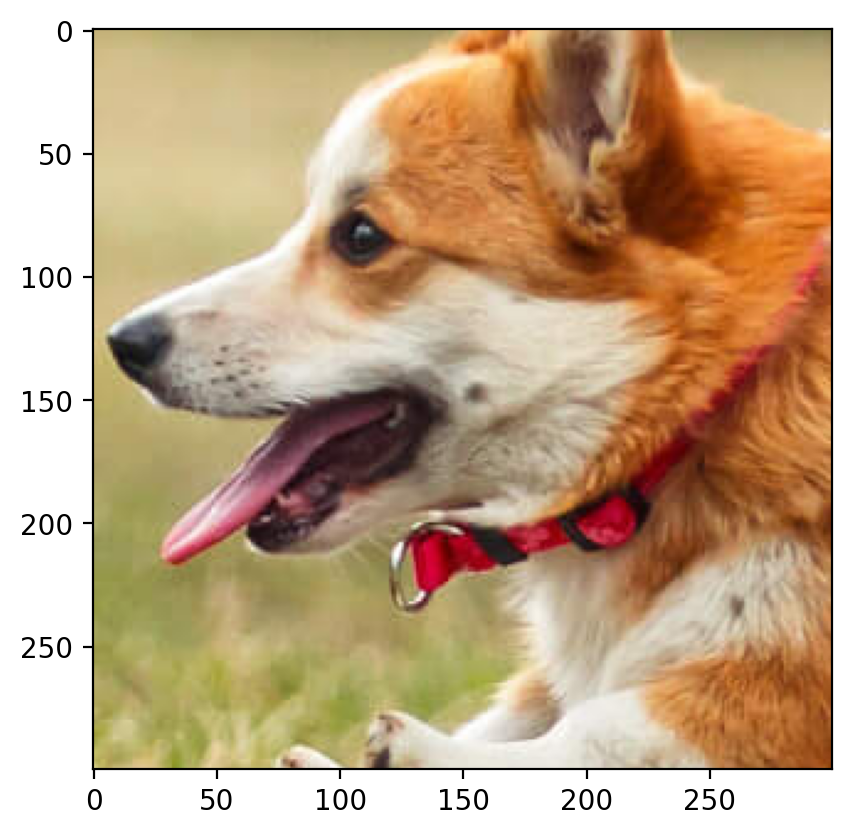

In [12]:
plt.imshow(rearrange(crop, 'c h w -> h w c'))

In [13]:
crop = crop.to(device)

In [14]:
def rectangle_patch(image, start_x, start_y, end_x, end_y):
    updated_image = image.clone().float()
    updated_image[:, start_x:end_x, start_y:end_y] = float('nan')
    return updated_image

In [15]:
# Modify the loss function to ignore NaN values

def factorize(A, k, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.001)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(10000):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss

In [16]:
def int_convertor(reconstructed_image_3D):
    reconstructed_image_3D_reshaped = reconstructed_image_3D.permute(1, 2, 0)
    reconstructed_image_np = reconstructed_image_3D_reshaped.detach().cpu().numpy()
    reconstructed_image_np = np.uint8(reconstructed_image_np)
    return torch.tensor(reconstructed_image_np).permute(2, 0, 1)

In [17]:
def plot_reconstructed_and_patched_image(reconstructed_image, patched_image, N):    
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(rearrange(reconstructed_image, 'c h w -> h w c').cpu().numpy())
    ax0.set_title(f"Reconstructed Image")
    ax1.imshow(rearrange(patched_image, 'c h w -> h w c').cpu().numpy())
    ax1.set_title(f"Original Image")
    for a in [ax0, ax1]:
        a.axis("off")

    plt.suptitle(f"Rectangular patch of size {N}x{N}", weight='bold')
    plt.tight_layout()

In [18]:
def rectangular_patch_image_reconstruction(image, r, N,patch_start_x=100, patch_start_y=150):
    
    patch_end_x = patch_start_x + N
    patch_end_y = patch_start_y + N
    
    # Mask the patch in the original image with NaN
    image_with_patch = rectangle_patch(image, patch_start_x, patch_start_y, patch_end_x, patch_end_y)
    
    # Converting into a 2D Tensor
    image_with_patch_2D = image_with_patch.reshape(-1, image_with_patch.size(-1))

    W, H, loss = factorize(image_with_patch_2D, r)
    reconstructed_image = torch.mm(W, H)

    # Converting back into a 3D Tensor
    reconstructed_image_3D = reconstructed_image.reshape(3, image.shape[1], -1)
    reconstructed_image_3D_updated = int_convertor(reconstructed_image_3D)
    image_with_patch = image_with_patch.to(img.dtype)

    
    plot_reconstructed_and_patched_image(reconstructed_image_3D_updated, image_with_patch, N)
    RMSE = torch.linalg.norm(reconstructed_image_3D - image)/(image.shape[0]*image.shape[1])**0.5
    PSNR = 20 * torch.log10(255/RMSE).item()
    
    return reconstructed_image_3D_updated, RMSE, PSNR

RMSE: tensor(136.5970, grad_fn=<DivBackward0>)
PSNR: 5.4219794273376465


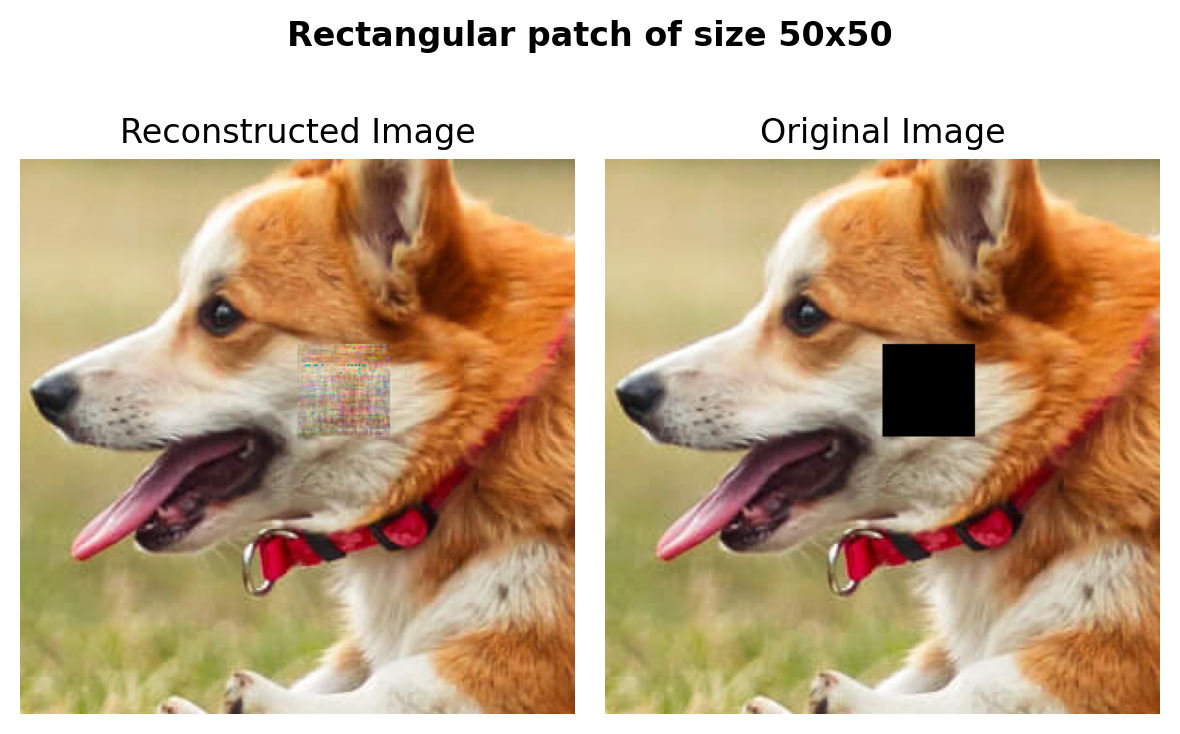

In [19]:
constructed_img, RMSE, PSNR = rectangular_patch_image_reconstruction(crop, 500, 50)
print("RMSE:", RMSE)
print("PSNR:", PSNR)

In [17]:
import math
def plot_reconstructed_and_patched_img(reconstructed_image, patched_image, N):    
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(rearrange(reconstructed_image, 'c h w -> h w c').cpu().numpy())
    ax0.set_title(f"Reconstructed Image")
    ax1.imshow(rearrange(patched_image, 'c h w -> h w c').cpu().numpy())
    ax1.set_title(f"Original Image")
    for a in [ax0, ax1]:
        a.axis("off")

    plt.tight_layout()

In [22]:
def plot_reconstructed_img_and_original(reconstructed_img_scaled, img, X_start, X_end, Y_start, Y_end, RMSE, PSNR, title):    
    fig = plt.figure(figsize=(5, 2.5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    reconstructed_img = img.clone()
    reconstructed_img[:, X_start:X_end, Y_start:Y_end] = torch.tensor(reconstructed_img_scaled)

    ax0.imshow(rearrange(reconstructed_img[:, 800-5*50:800+5*50, 925-5*50:925+5*50], 'c h w -> h w c'))
    ax0.set_title(f"Reconstructed Image")

    ax1.imshow(rearrange(img[:, 800-5*50:800+5*50, 925-5*50:925+5*50], 'c h w -> h w c'))
    ax1.set_title(f"Original Image")

    for a in [ax0, ax1]:
        a.axis("off")

    plt.suptitle(title, weight='bold')
    fig.text(0.5, 0.01, f"RMSE = {RMSE:.2f}, PSNR = {PSNR:.2f}", ha='center', weight='bold')
    plt.tight_layout()


def reconstruct_img_patch(img, k, X_start, X_end, Y_start, Y_end, title):
    new_img = img[:, X_start:X_end, Y_start:Y_end]
    new_img = new_img.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
    # Converting in 2D tensor
    new_img_2D = new_img.reshape(-1, new_img.size(-1))

    # Gradient Descent Method
    W, H, loss = factorize(new_img_2D, k)
    with torch.no_grad():
        reconstructed_img = torch.mm(W, H)

    # Converting back into 3D Tensor
    reconstructed_img3D = reconstructed_img.reshape(3, new_img.shape[1], -1)

    # trying to get all values in range [0, 255]
    reconstructed_img_scaled = reconstructed_img3D/255

    # Calculating metrics
    RMSE = torch.sqrt(((reconstructed_img3D - new_img) ** 2).mean()).item()
    if RMSE == 0:
        PSNR = float('inf')
    else:
        PSNR = 10 * (math.log10((255)*2)/((RMSE)*2))

    # Plotting Reconstructed and Original Image
    new_img = new_img.to(img.dtype)
    plot_reconstructed_img_and_original(reconstructed_img_scaled, img, X_start, X_end, Y_start, Y_end, RMSE, PSNR, title)
    plot_reconstructed_and_patched_img(reconstructed_img_scaled, new_img, 50)
    
    
    return new_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

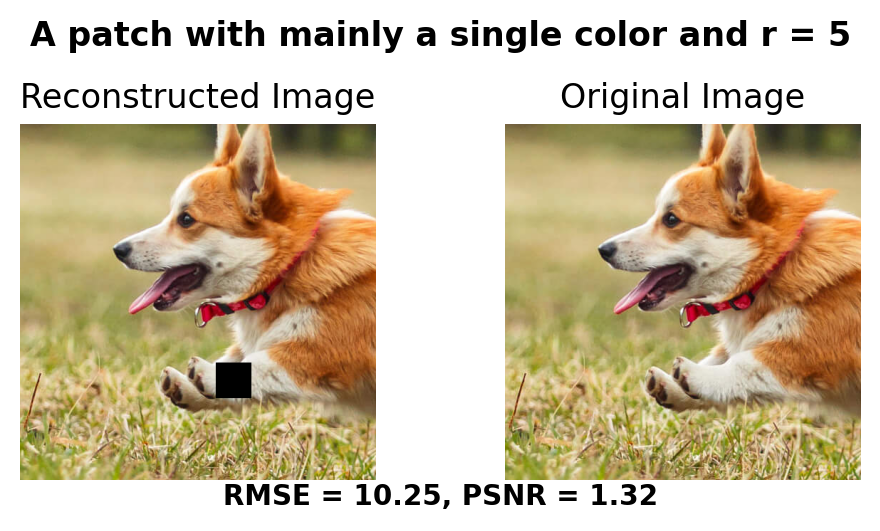

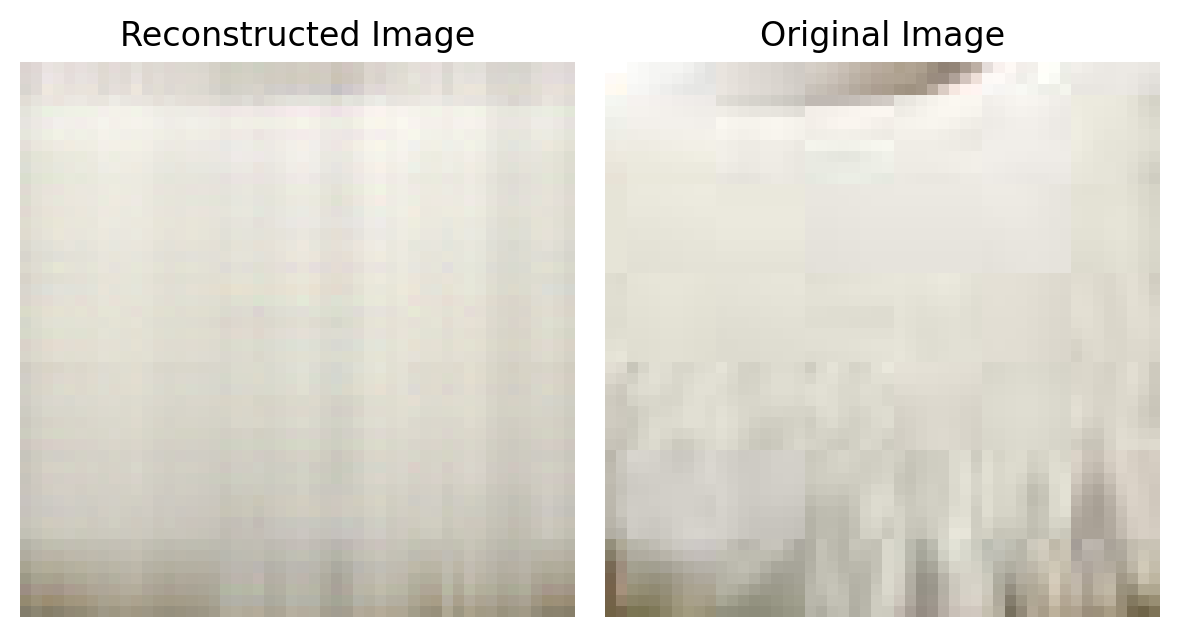

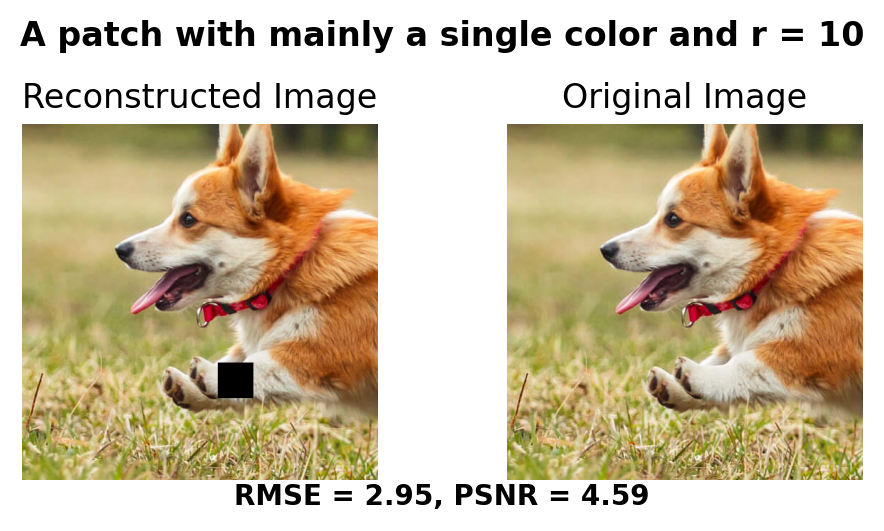

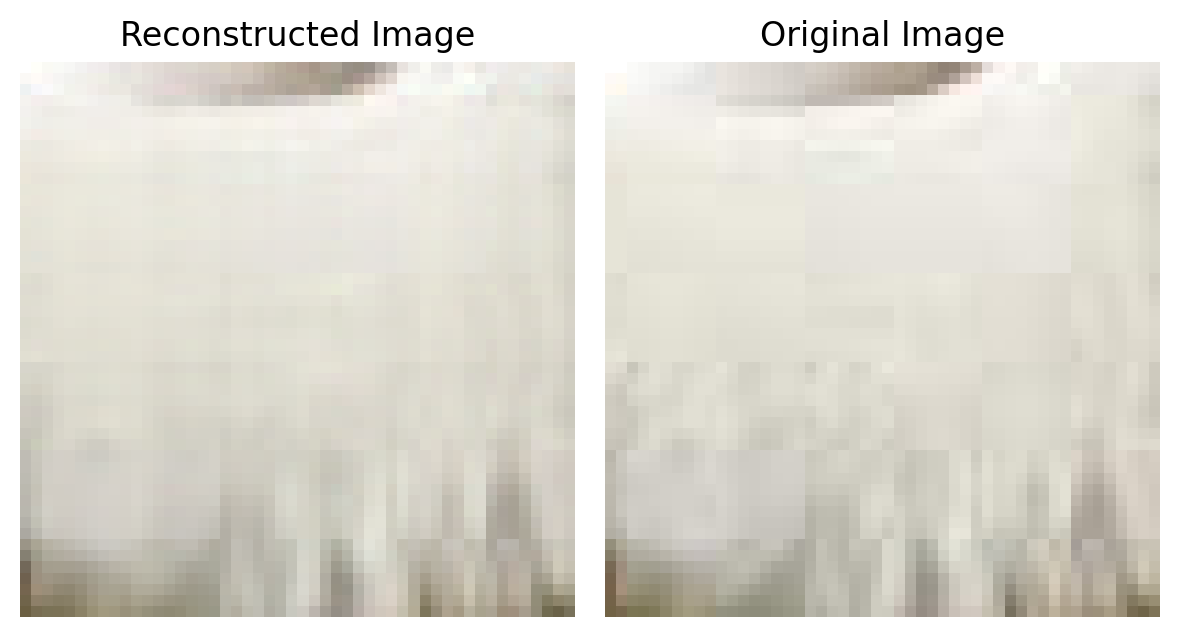

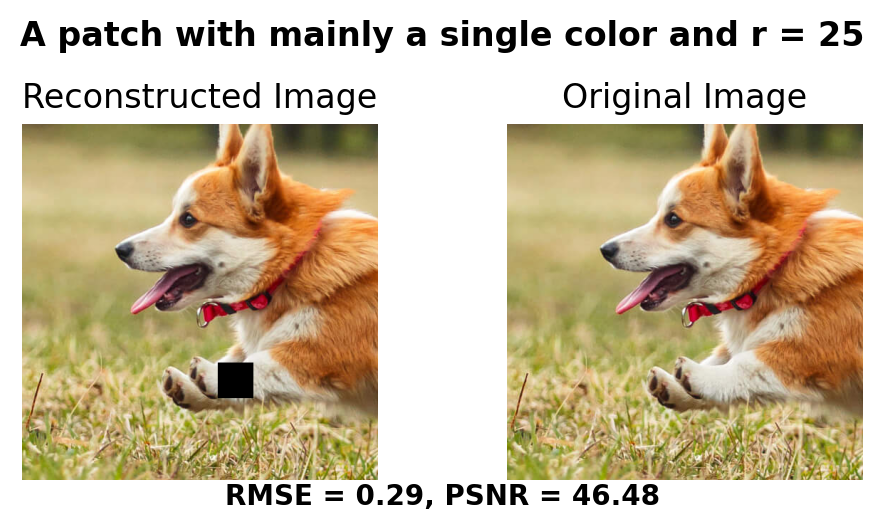

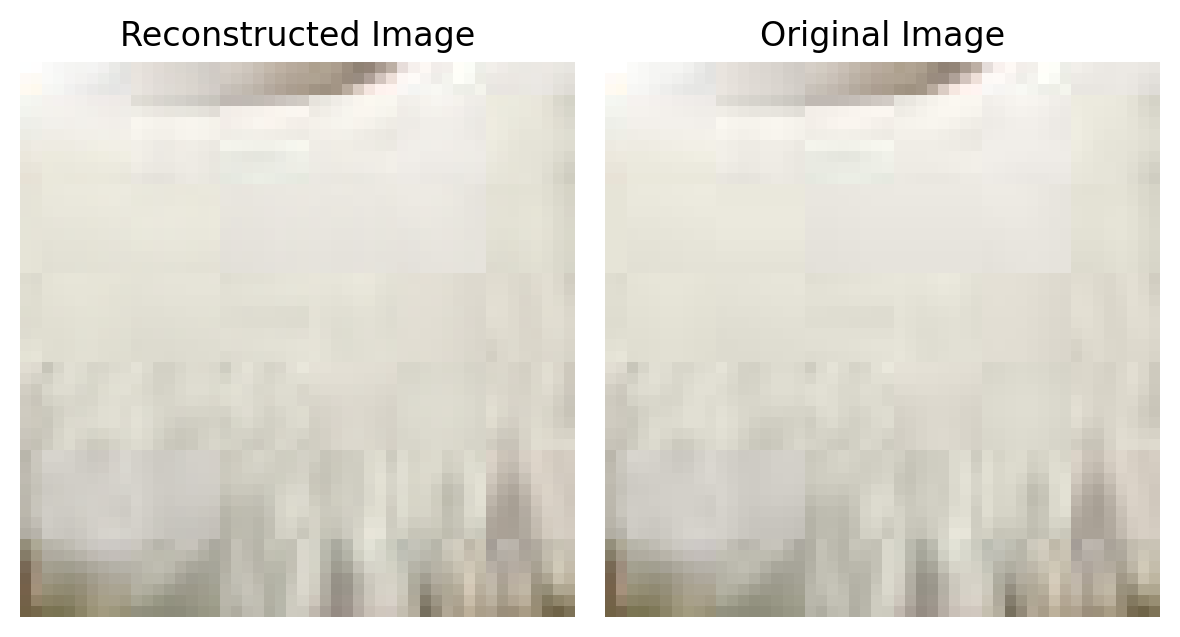

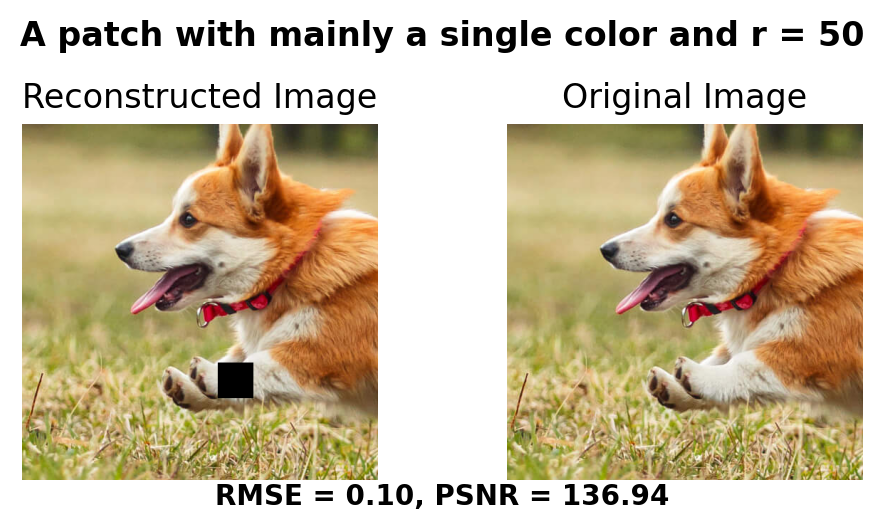

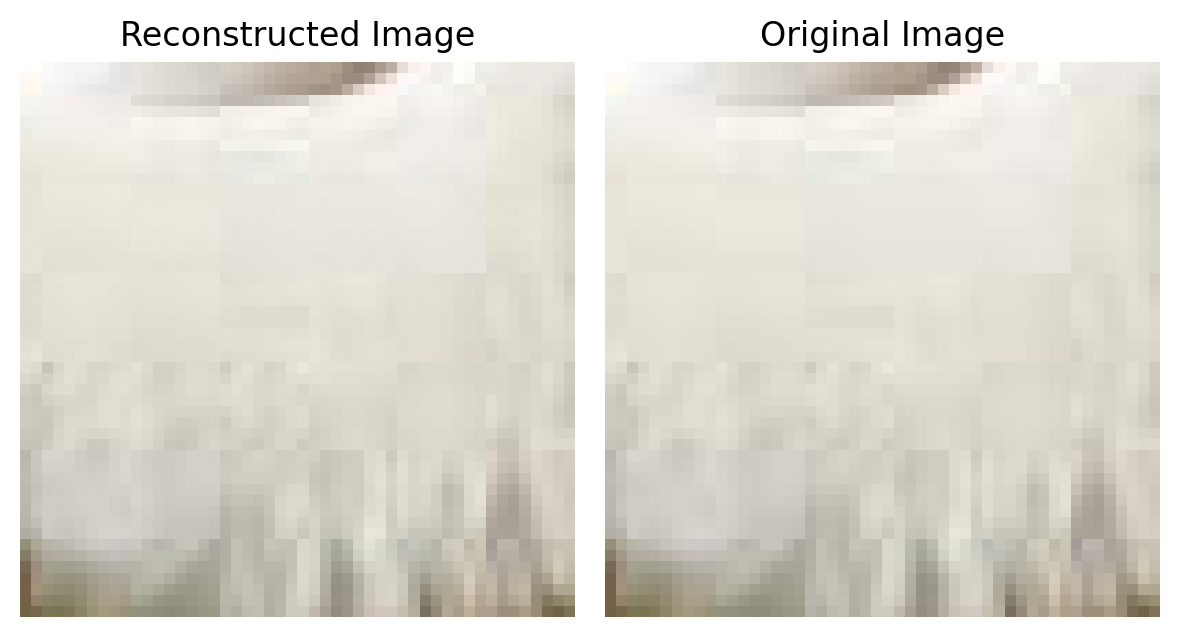

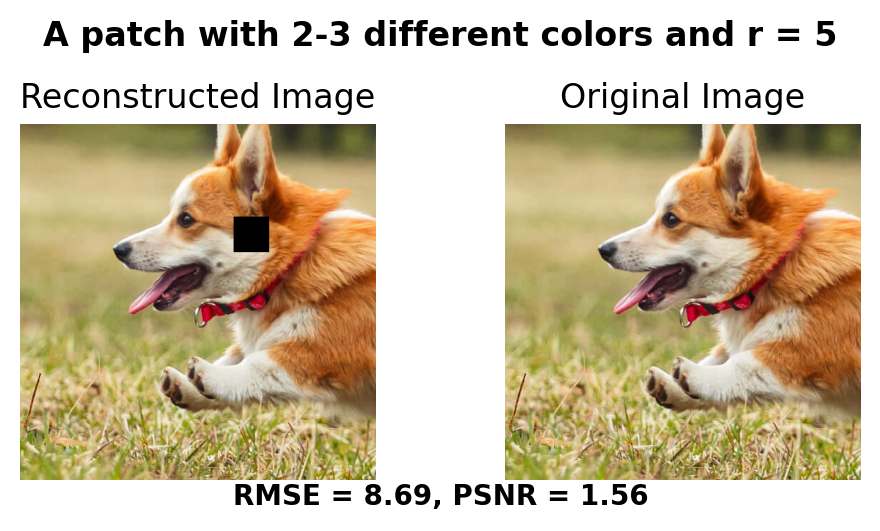

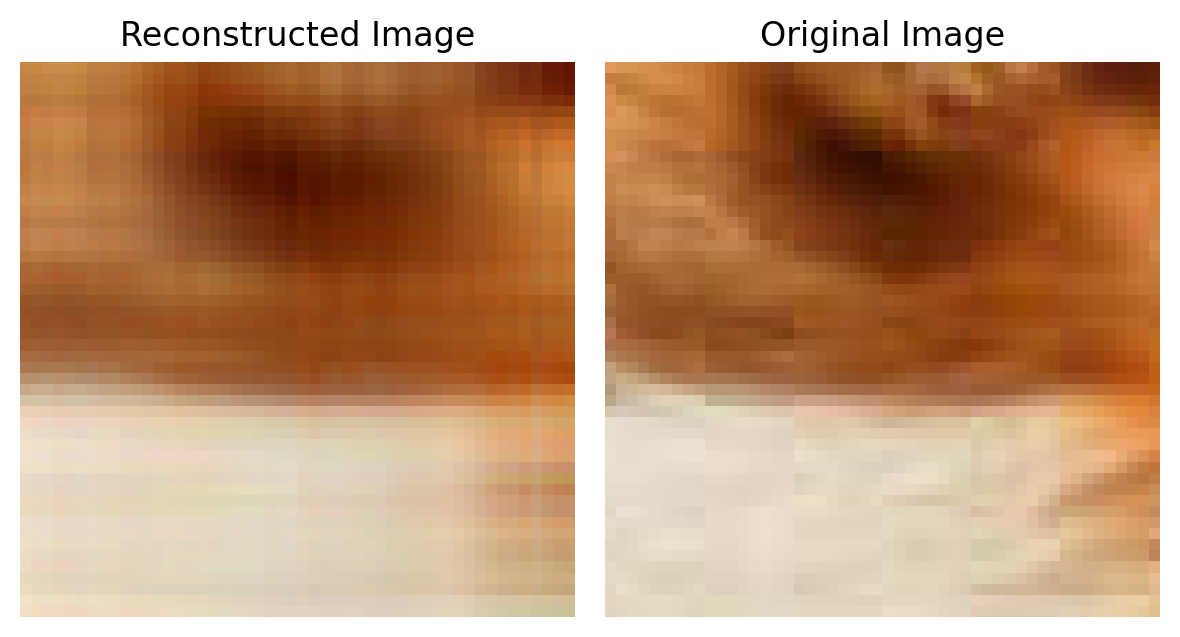

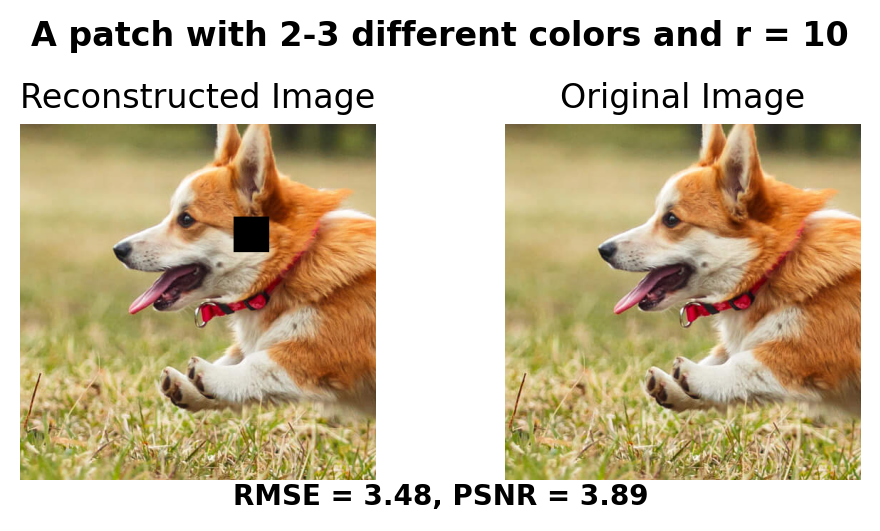

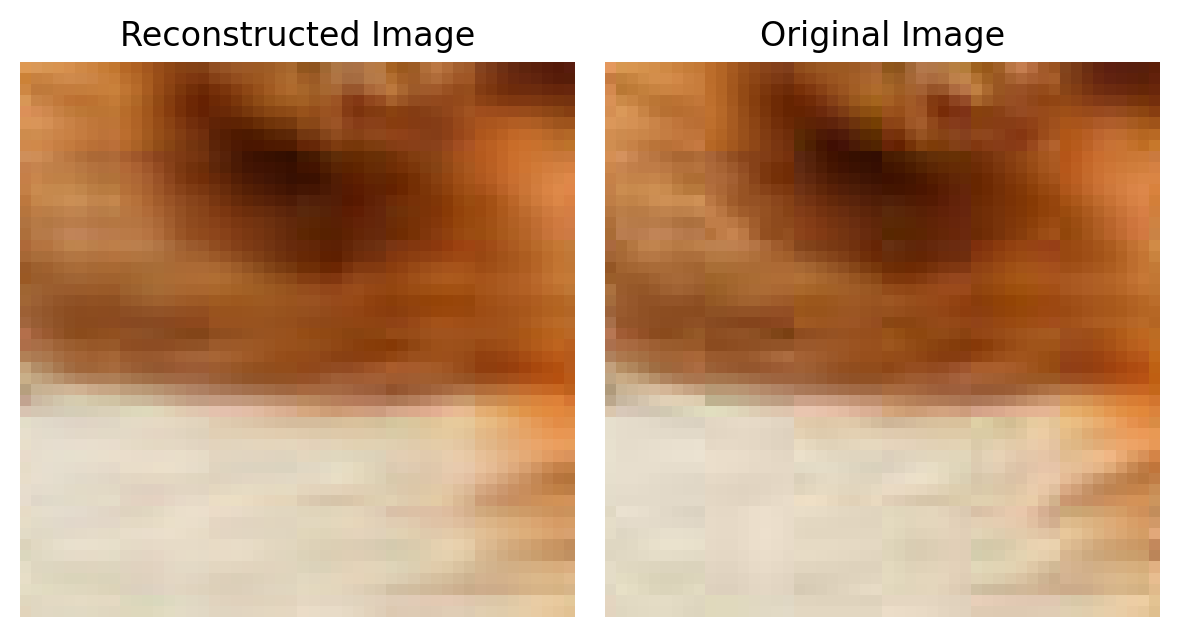

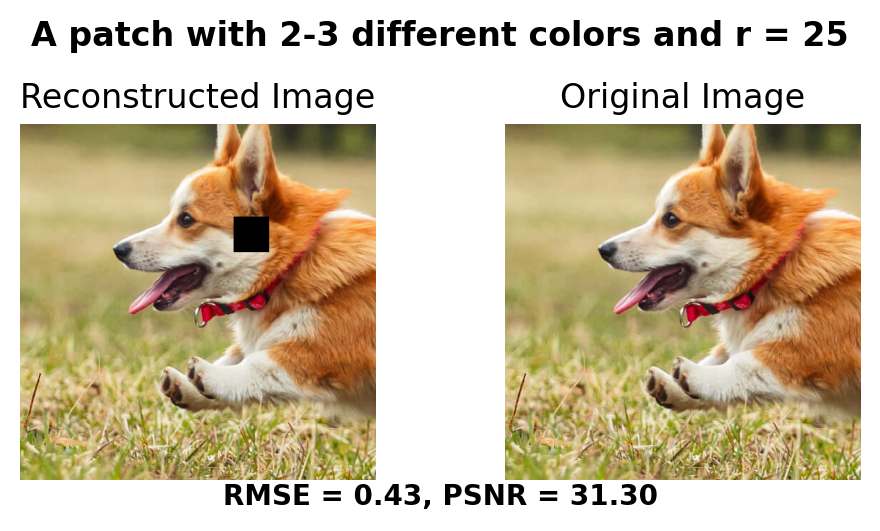

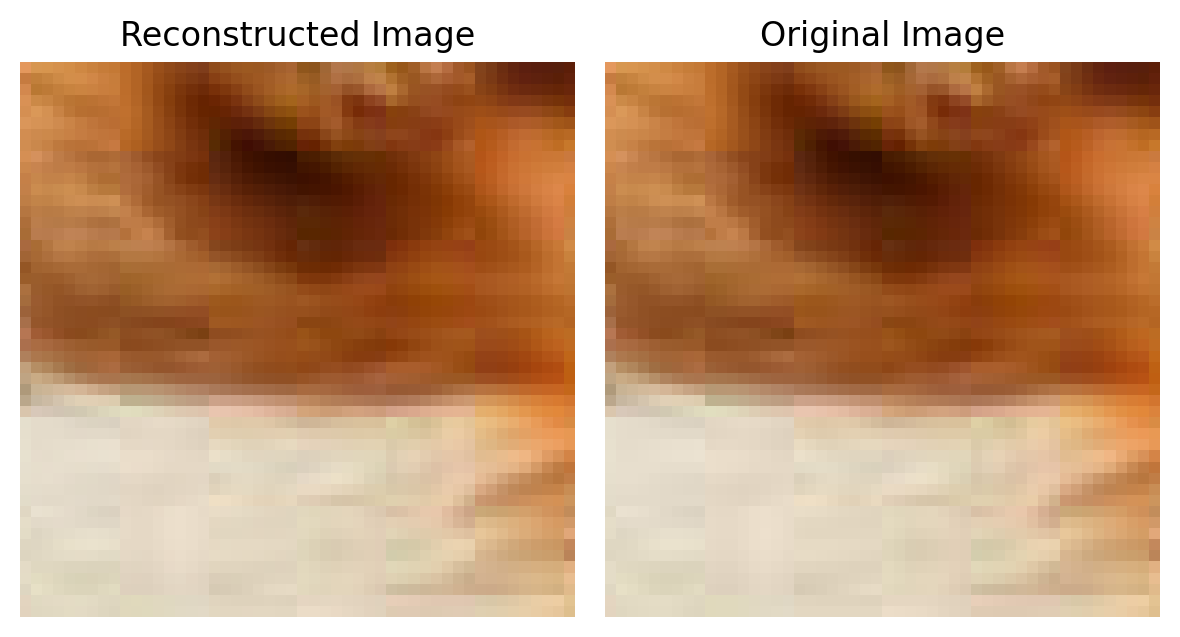

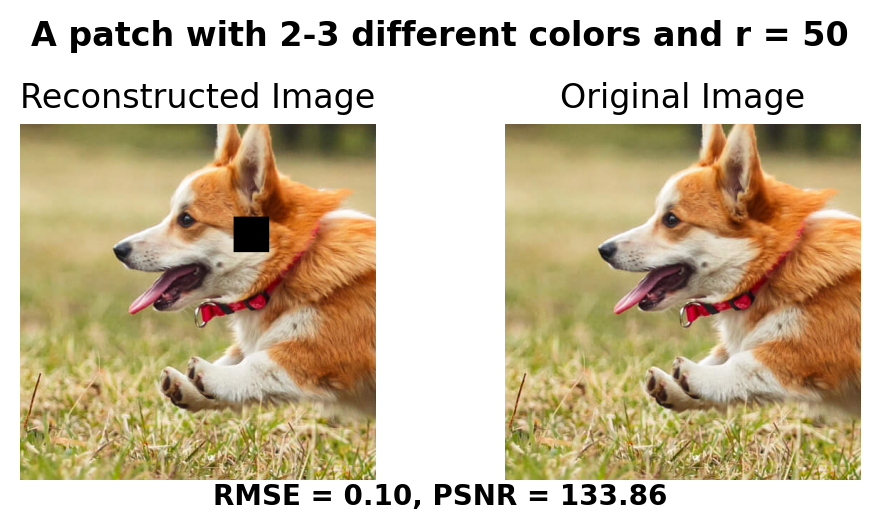

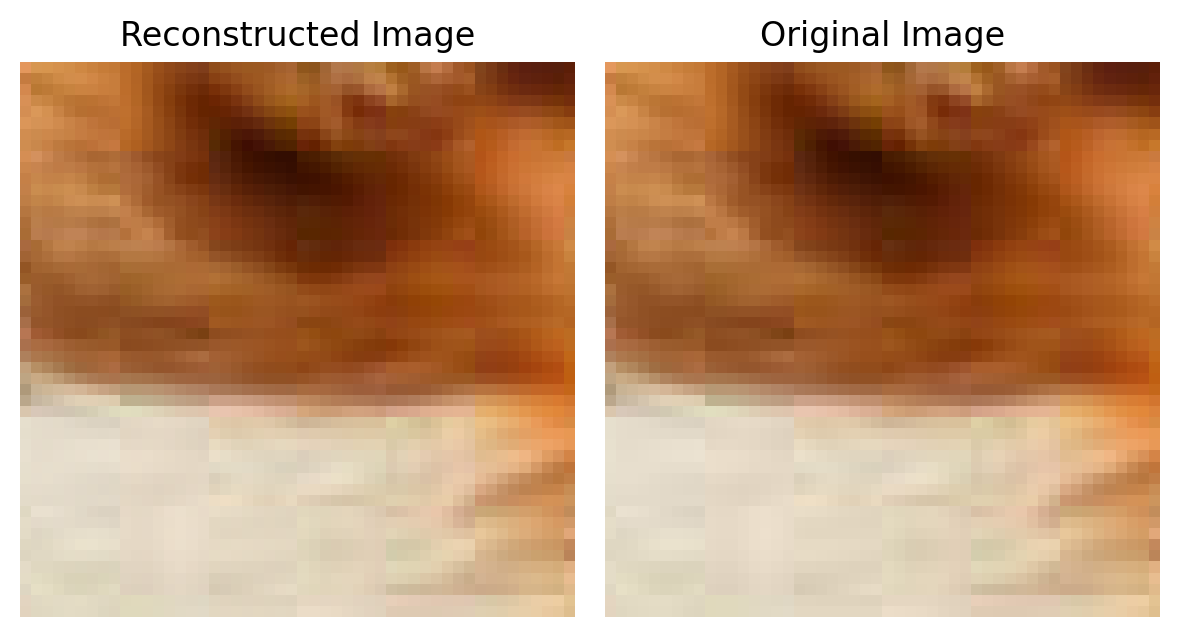

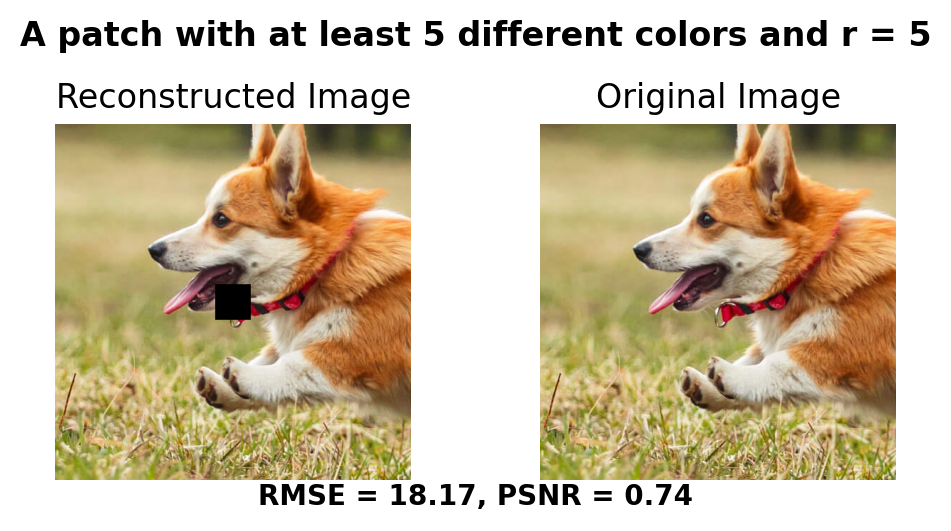

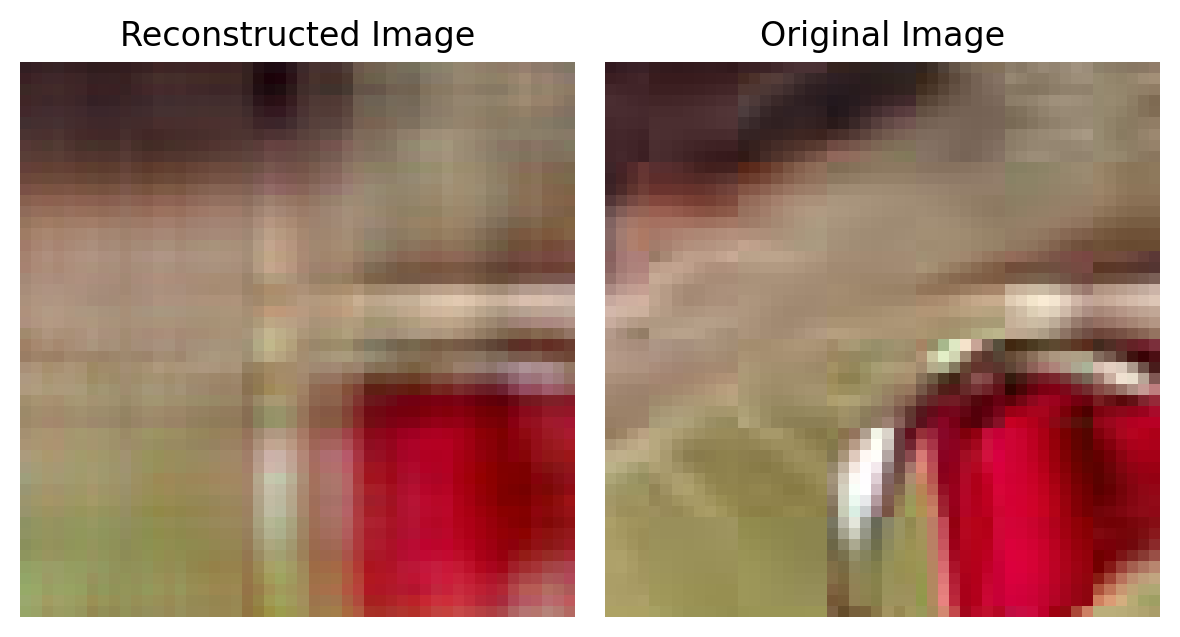

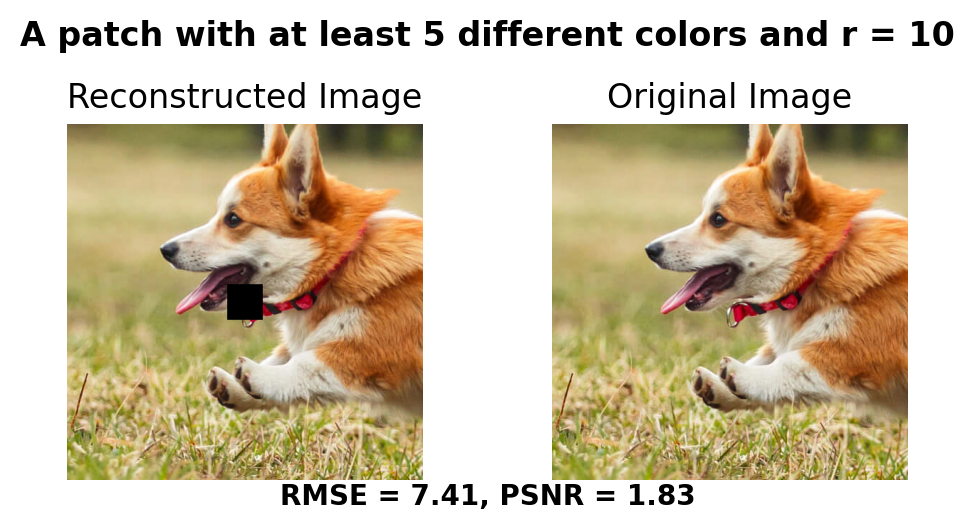

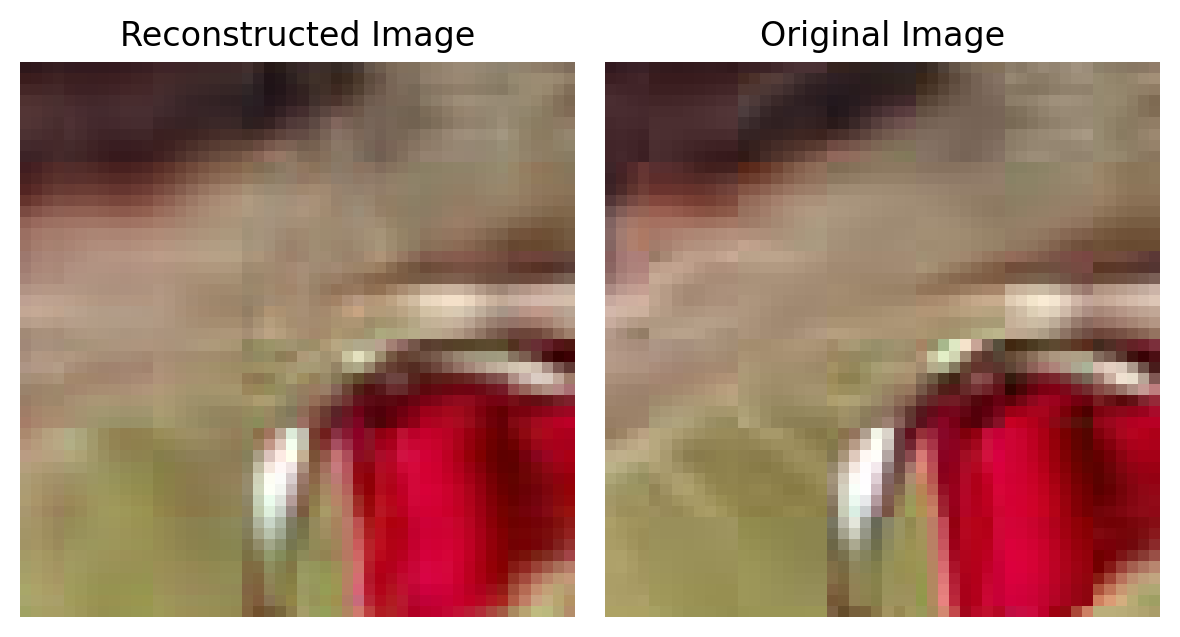

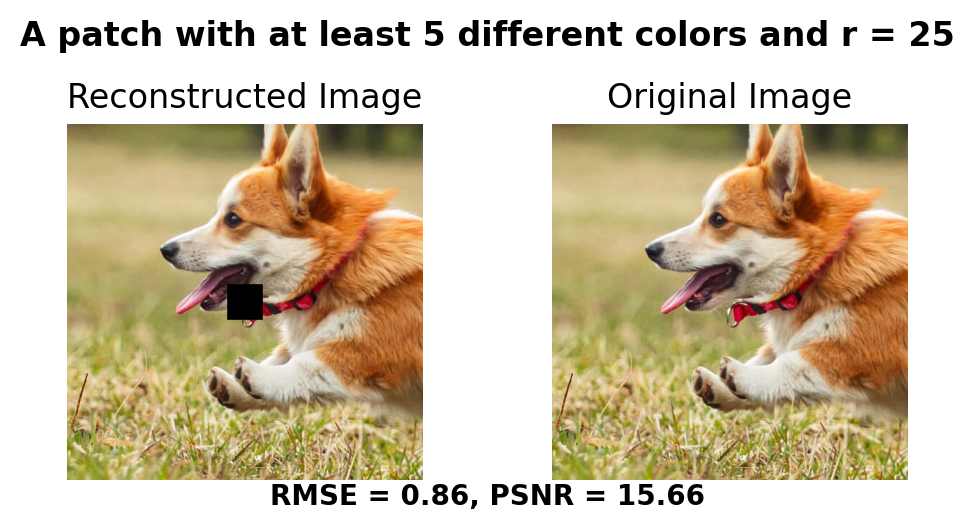

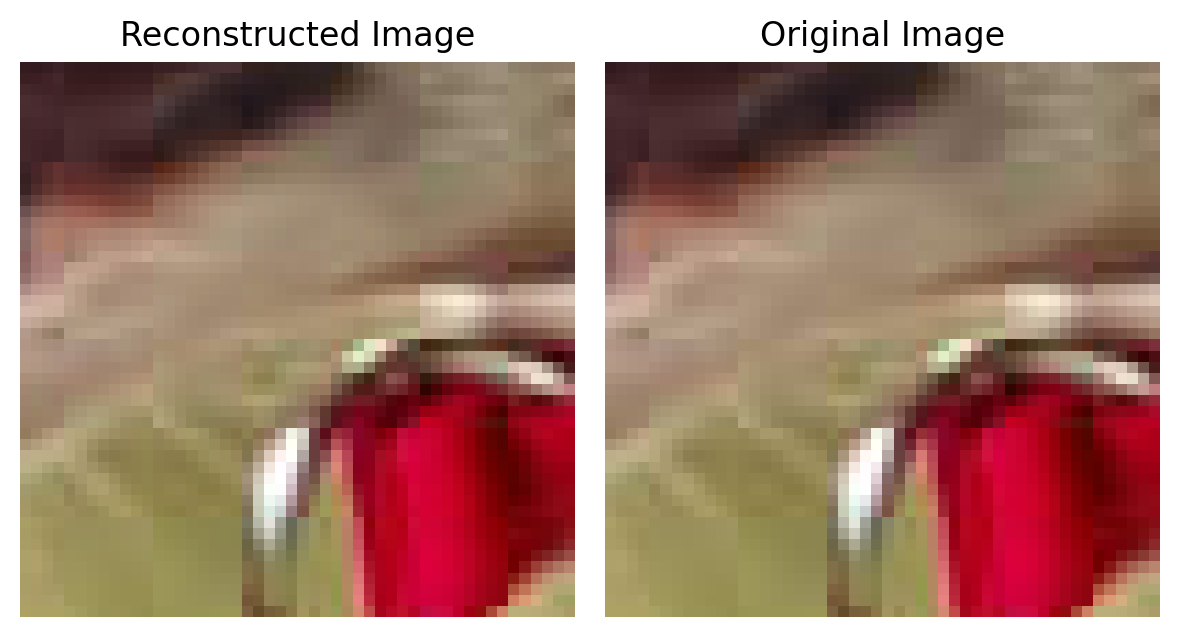

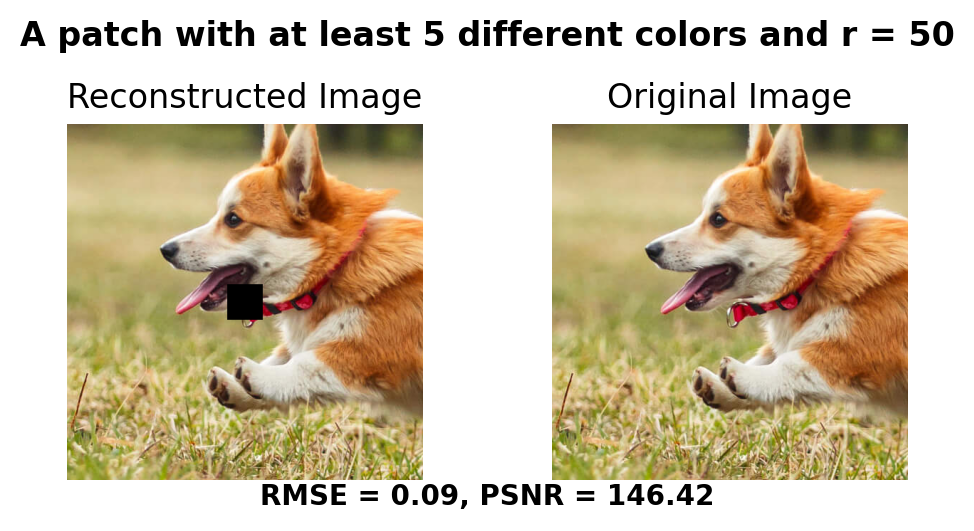

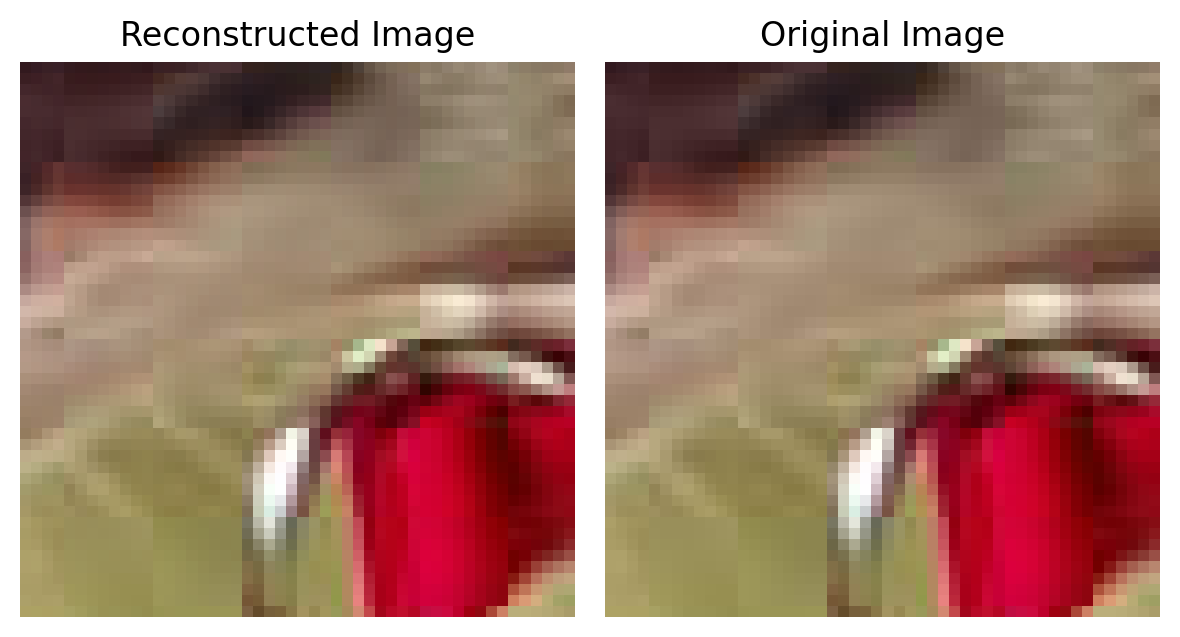

In [24]:
r = [5, 10, 25, 50]

for i in r:
    a = reconstruct_img_patch(img, i, 885, 935, 950, 1000, f"A patch with mainly a single color and r = {i}")

for i in r:
    a = reconstruct_img_patch(img, i, 680, 730, 975, 1025, f"A patch with 2-3 different colors and r = {i}")

for i in r:
    a = reconstruct_img_patch(img, i, 775, 825, 900, 950, f"A patch with at least 5 different colors and r = {i}")